## **Interpretable analysis of CTCNet learning**

In [1]:
from pprint import pprint
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from utils import create_data_loaders
from sklearn.decomposition import PCA

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load trained model

In [2]:
model_path = Path("/Users/patmccarthy/Documents/ThalamoCortex/results/11_02_24_driver_mnist/0_CTCNet_TC_add_reciprocal_readout/model.pth")

In [3]:
model = torch.load(model_path)

In [4]:
model.keys()

odict_keys(['thal.0.weight', 'thal.0.bias', 'thal_to_ctx1_projections.weight', 'thal_to_ctx1_projections.bias', 'thal_to_ctx2_projections.weight', 'thal_to_ctx2_projections.bias', 'thal_to_readout_projections.weight', 'thal_to_readout_projections.bias', 'ctx1.0.weight', 'ctx1.0.bias', 'ctx2.0.weight', 'ctx2.0.bias', 'readout.0.weight', 'readout.0.bias'])

Plot weights for input layer neurons according to topographic connectivity to input 

In [5]:
input_layer_weights = model["ctx1.0.weight"]

In [6]:
input_layer_weights.shape

torch.Size([128, 784])

In [7]:
neuron_id = 1
weights_neuron = input_layer_weights[neuron_id, :].detach().numpy()
weights_neuron_reshaped = np.reshape(weights_neuron, newshape=[28, 28], order="C")

In [8]:
# get min and max vals to plot colourmap
print(f"Min val: {np.min(weights_neuron_reshaped):.3f}, Max val: {np.max(weights_neuron_reshaped):.3f}")

Min val: -0.685, Max val: 0.518


In [9]:
clims = [-1.5, 1.5]

Text(0.5, 1.0, 'input RF')

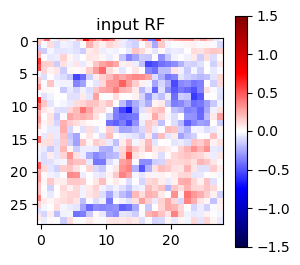

In [10]:
cmap = cm.get_cmap("seismic")
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(weights_neuron_reshaped, cmap=cmap)
psm = ax.pcolormesh(weights_neuron_reshaped, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
fig.colorbar(psm, ax=ax)
ax.set_title("input RF")

In [11]:
def get_neuron_weights(weights, neuron_id):
    weights_neuron = weights[neuron_id, :].detach().numpy()
    weights_neuron_reshaped = np.reshape(weights_neuron, newshape=[28, 28], order="C")
    return weights_neuron_reshaped

In [12]:
def plot_receptive_field(weights, ax, cmap, clims, title=None):
    ax.imshow(weights, cmap=cmap)
    ax.set_title(title)
    ax.set_xticks([], [])
    ax.set_yticks([], [])

Text(0.5, 0.98, 'input layer receptive fields')

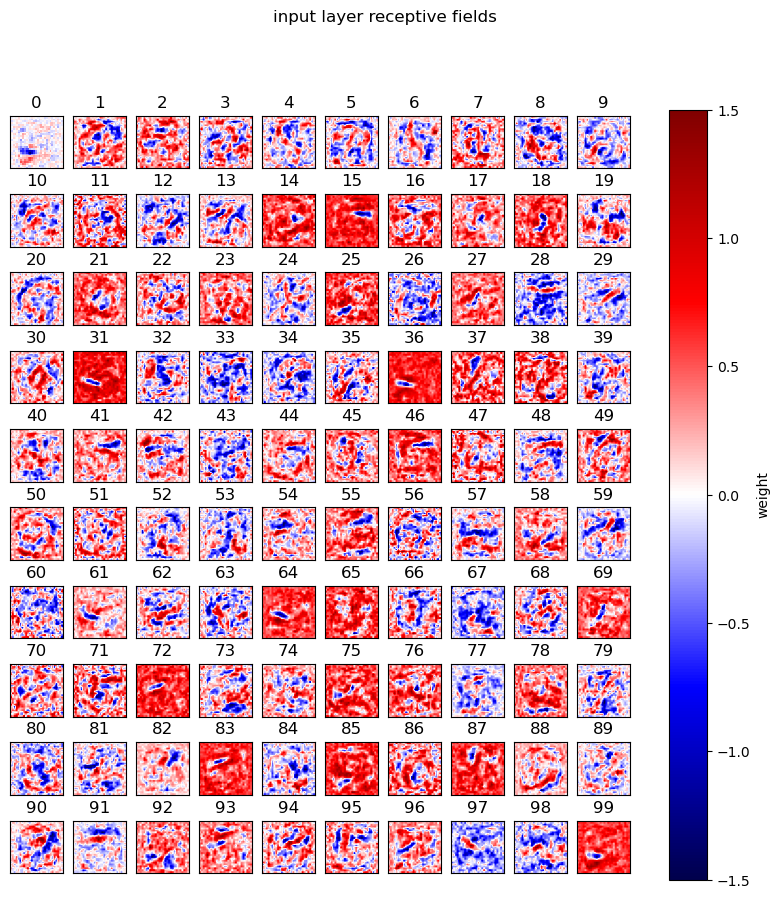

In [13]:
cmap = cm.get_cmap("seismic")
clims = [-1.5, 1.5]

fig, ax = plt.subplots(10, 10, figsize=(10, 10))

for neuron_id in range(100):

    row_idx = neuron_id // 10
    col_idx = neuron_id % 10

    weights_this_neuron = get_neuron_weights(weights=input_layer_weights,
                                             neuron_id=neuron_id)
    plot_receptive_field(weights=weights_this_neuron,
                         ax=ax[row_idx, col_idx],
                         cmap=cmap,
                         clims=clims,
                         title=neuron_id)

psm = ax[0, 0].pcolormesh(weights_this_neuron, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
cbar = fig.colorbar(psm, ax=ax)
cbar.set_label("weight")
fig.suptitle("input layer receptive fields")
# fig.set_tight_layout(True)

Decompose training set and plot principal components

In [102]:
trainset_loader, testset_loader, metadata = create_data_loaders(dataset="MNIST", norm="normalise", batch_size=32, save_path="Users/patmccarthy/Desktop")

In [84]:
# load full training set
X_all = []
y_all = []
for X, y in iter(trainset_loader):
    X_all.append(X.detach().numpy()[:, 0, :, :])
    y_all.append(y.detach().numpy()[:])

In [85]:
X_all_arr = np.array(X_all)
y_all_arr = np.array(y_all)
X_all_reshaped = np.reshape(X_all_arr, newshape=(X_all_arr.shape[0] * X_all_arr.shape[1], X_all_arr.shape[2], X_all_arr.shape[3]))
y_all_reshaped = np.reshape(y_all_arr, newshape=(y_all_arr.shape[0] * y_all_arr.shape[1]))
X_all_flat = np.reshape(X_all_reshaped, newshape=(X_all_reshaped.shape[0], X_all_reshaped.shape[1] * X_all_reshaped.shape[2]))

In [86]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(X_all_flat)

PCA(n_components=10)

Text(0, 0.5, 'explained variance')

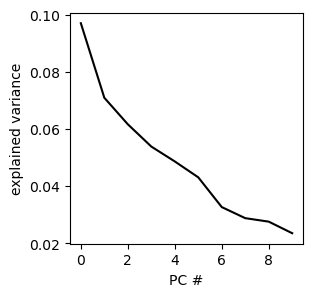

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(pca.explained_variance_ratio_, c="k")
ax.set_xlabel("PC #")
ax.set_ylabel("explained variance")

In [88]:
X_components_reshaped = np.reshape(pca.components_, newshape=(pca.components_.shape[0], 28, 28))

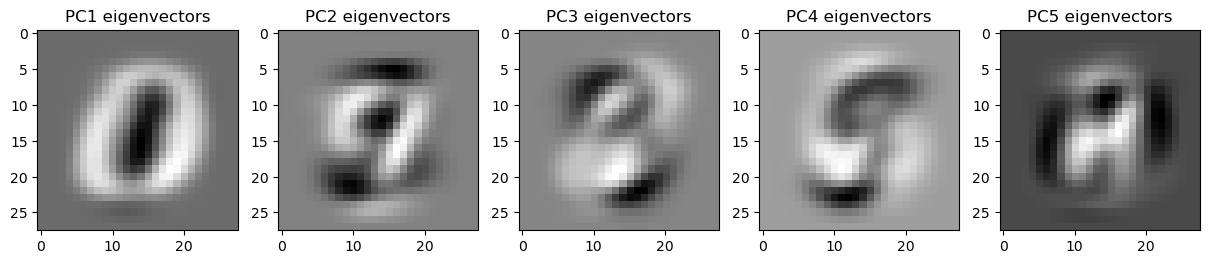

In [89]:
n_plot = 5
fig, ax = plt.subplots(1, n_plot, figsize=(3 * n_plot, 3))
for comp_idx in range(n_plot):
    cmap = cm.get_cmap("grey")
    ax[comp_idx].imshow(X_components_reshaped[comp_idx, :, :], cmap=cmap)
    ax[comp_idx].set_title(f"PC{comp_idx+1} eigenvectors")

Plot variance of training set

In [90]:
X_var = np.var(X_all_reshaped, axis=0)

Text(0.5, 1.0, 'training set variance')

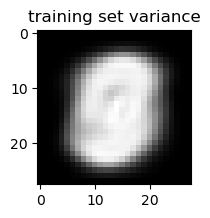

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(X_var, cmap="grey")
ax.set_title("training set variance")

In [95]:
model["thal.0.weight"].shape

torch.Size([64, 256])

Plot weight distributions

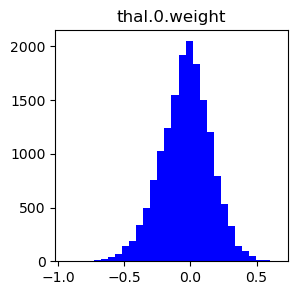

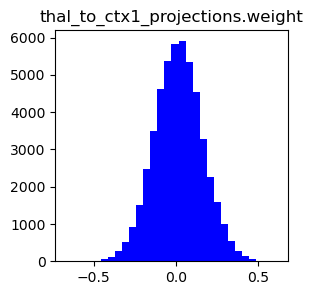

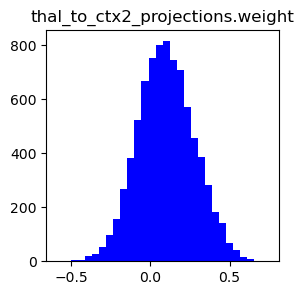

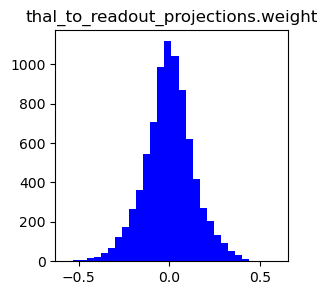

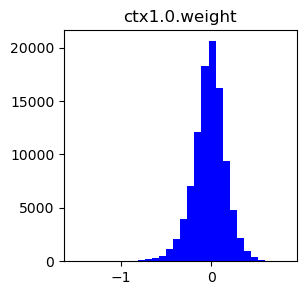

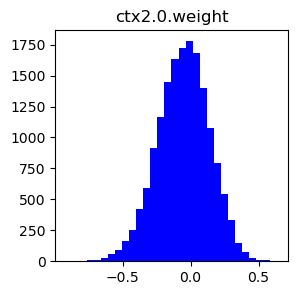

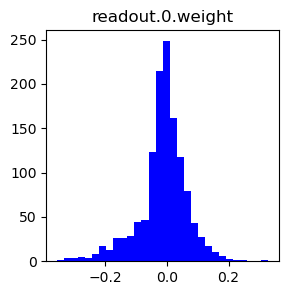

In [100]:
for param_set_name, params in model.items():
    if "weight" in param_set_name:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        params_flat = params.flatten()
        ax.hist(params_flat, bins=30, facecolor="b")
        ax.set_title(f"{param_set_name}")